# joule-profiler Phases Analysis

Analyze energy consumption across different execution phases.

## RAPL Domain Hierarchy

**Important:** RAPL domains are hierarchical:
- `PSYS` = Platform (entire system)
- `PACKAGE` = CPU package (includes CORE + UNCORE)
- `CORE` = CPU cores (subset of PACKAGE)
- `UNCORE` = Uncore (subset of PACKAGE)

**Do not sum all domains** as this would double-count energy!

## Load Data

This notebook works with phases mode data in both formats:
- JSON: `phases.json`, `phases-iterations.json`
- CSV: `phases.csv`, `phases-iterations.csv`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Phases Mode - Single Run (JSON)

In [2]:
# Load phases.json
data = pd.read_json('../examples/data/phases.json', typ='series')

print(f"Mode: {data['mode']}")
print(f"Tokens: {data['token_start']} -> {data['token_end']}")
print(f"Number of phases: {len(data['phases'])}")

Mode: phases
Tokens: __WORK_START__ -> __WORK_END__
Number of phases: 4


In [3]:
# Convert to DataFrame with energy in Joules
df_phases_json = pd.DataFrame([
    {
        'Phase': phase['name'],
        **{domain: uj / 1_000_000 for domain, uj in phase['result']['energy_uj'].items()},
        'Duration (s)': phase['result']['duration_ms'] / 1000
    }
    for phase in data['phases']
])

df_phases_json

,Phase,CORE_0,PACKAGE-0_0,PSYS_1,UNCORE_0,Duration (s)
0,global (START -> END),0.170471,0.295043,0.744444,0.001404,0.030
1,pre_work (START -> __WORK_START__),0.114319,0.218933,0.594786,0.001404,0.024
2,work (__WORK_START__ -> __WORK_END__),0.036560,0.049133,0.095642,0.000000,0.003
3,post_work (__WORK_END__ -> END),0.019592,0.026977,0.054016,0.000000,0.002


In [4]:
# Get domain columns
domain_cols_json = [col for col in df_phases_json.columns if col not in ['Phase', 'Duration (s)']]
print(f"Available domains: {', '.join(domain_cols_json)}")

Available domains: CORE_0, PACKAGE-0_0, PSYS_1, UNCORE_0


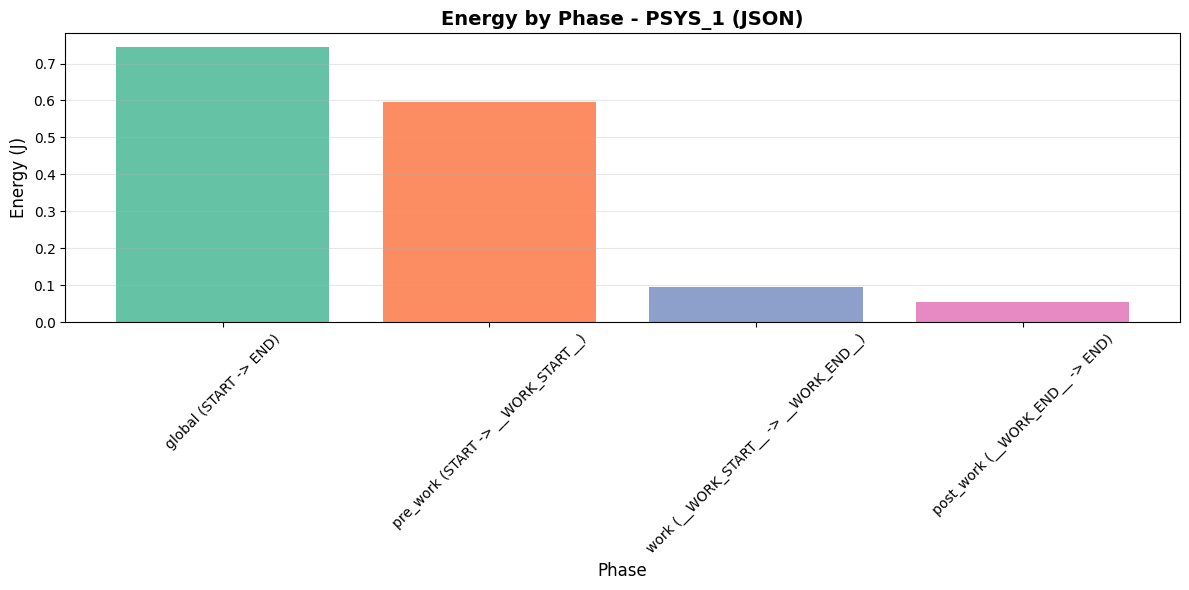

In [5]:
# Visualize energy by phase (JSON)
fig, ax = plt.subplots(figsize=(12, 6))

# Select primary domain (PSYS or PACKAGE)
primary_domain = None
for domain in ['PSYS_1', 'PACKAGE-0_0']:
    if domain in domain_cols_json:
        primary_domain = domain
        break

if primary_domain:
    colors = sns.color_palette('Set2', len(df_phases_json))
    ax.bar(df_phases_json['Phase'], df_phases_json[primary_domain], color=colors)
    ax.set_title(f'Energy by Phase - {primary_domain} (JSON)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Energy (J)', fontsize=12)
    ax.set_xlabel('Phase', fontsize=12)
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()

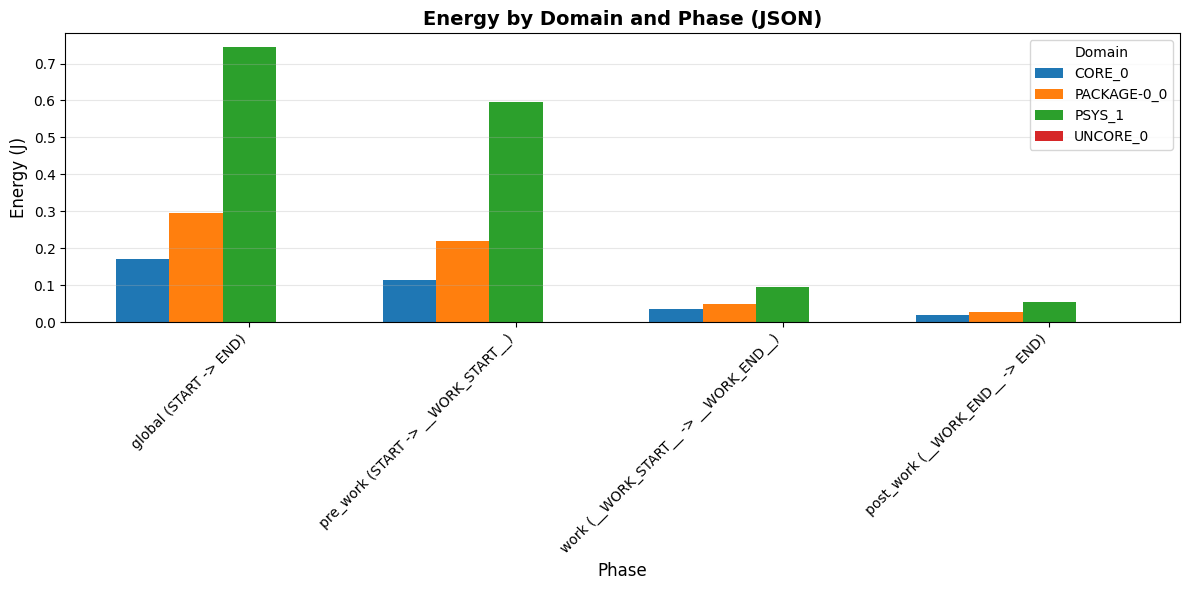

In [6]:
# Compare all domains across phases (JSON)
fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(df_phases_json))
width = 0.8 / len(domain_cols_json)

for i, domain in enumerate(domain_cols_json):
    offset = (i - len(domain_cols_json) / 2) * width
    ax.bar([xi + offset for xi in x], df_phases_json[domain], width, label=domain)

ax.set_title('Energy by Domain and Phase (JSON)', fontsize=14, fontweight='bold')
ax.set_ylabel('Energy (J)', fontsize=12)
ax.set_xlabel('Phase', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(df_phases_json['Phase'], rotation=45, ha='right', fontsize=10)
ax.legend(title='Domain')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()

## 2. Phases Mode - Single Run (CSV)

In [7]:
# Load phases.csv - directly usable!
df_phases_csv = pd.read_csv('../examples/data/phases.csv', sep=';')
df_phases_csv

,phase_name,CORE_0_uj,PACKAGE-0_0_uj,PSYS_1_uj,UNCORE_0_uj,duration_ms,exit_code
0,global (START -> END),163208,305785,797667,244,34,0
1,pre_work (START -> __WORK_START__),96253,216063,631895,244,28,0
2,work (__WORK_START__ -> __WORK_END__),38452,51636,97107,0,3,0
3,post_work (__WORK_END__ -> END),28503,38086,68665,0,2,0


In [8]:
# Get domain columns
domain_cols_csv = [col for col in df_phases_csv.columns if col.endswith('_uj')]
print(f"Available domains: {', '.join([col.replace('_uj', '') for col in domain_cols_csv])}")

Available domains: CORE_0, PACKAGE-0_0, PSYS_1, UNCORE_0


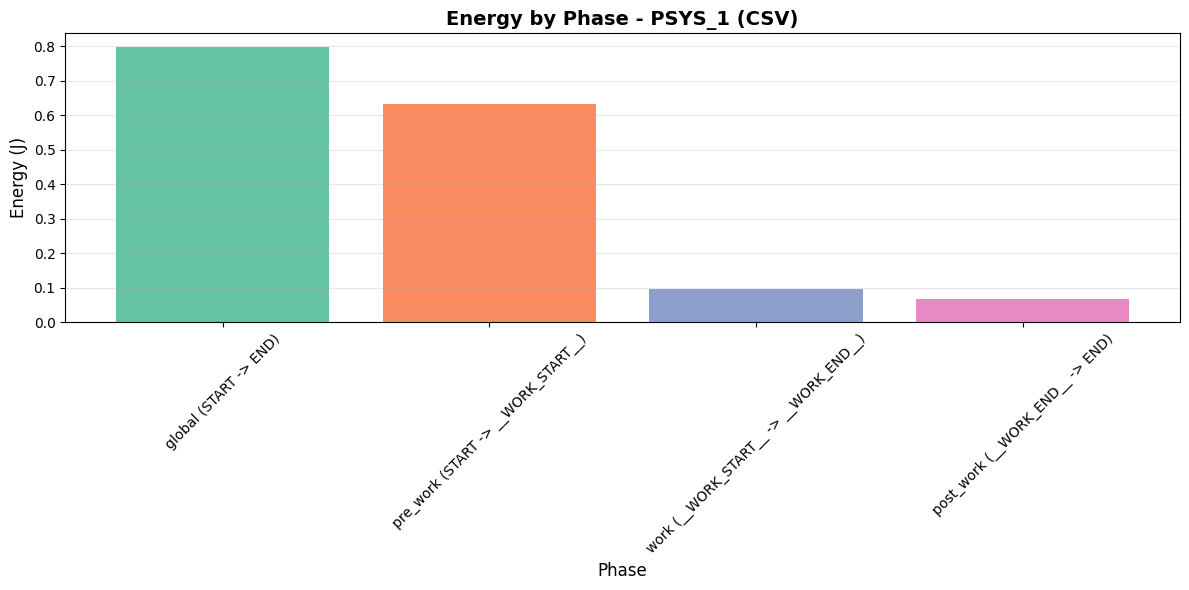

In [9]:
# Visualize energy by phase (CSV)
fig, ax = plt.subplots(figsize=(12, 6))

# Select primary domain
primary_domain_csv = None
for domain in ['PSYS_1_uj', 'PACKAGE-0_0_uj']:
    if domain in domain_cols_csv:
        primary_domain_csv = domain
        break

if primary_domain_csv:
    colors = sns.color_palette('Set2', len(df_phases_csv))
    # Convert to J for display
    ax.bar(df_phases_csv['phase_name'], df_phases_csv[primary_domain_csv] / 1_000_000, color=colors)
    ax.set_title(f'Energy by Phase - {primary_domain_csv.replace("_uj", "")} (CSV)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Energy (J)', fontsize=12)
    ax.set_xlabel('Phase', fontsize=12)
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()

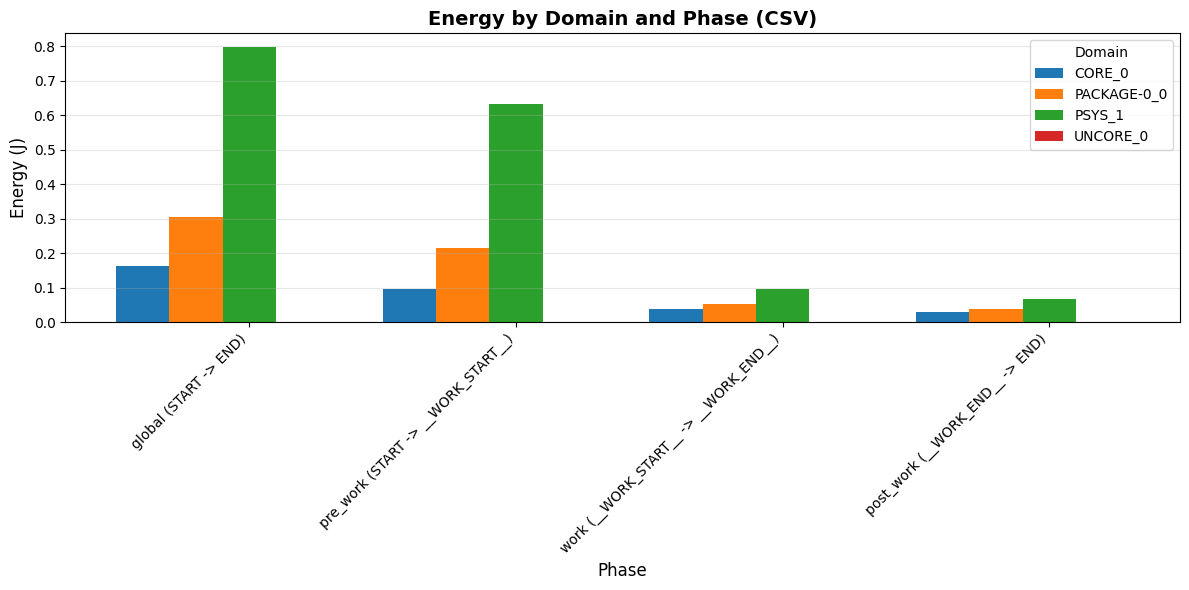

In [10]:
# Compare all domains across phases (CSV)
fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(df_phases_csv))
width = 0.8 / len(domain_cols_csv)

for i, domain in enumerate(domain_cols_csv):
    offset = (i - len(domain_cols_csv) / 2) * width
    # Convert to J for display
    label = domain.replace('_uj', '')
    ax.bar([xi + offset for xi in x], df_phases_csv[domain] / 1_000_000, width, label=label)

ax.set_title('Energy by Domain and Phase (CSV)', fontsize=14, fontweight='bold')
ax.set_ylabel('Energy (J)', fontsize=12)
ax.set_xlabel('Phase', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(df_phases_csv['phase_name'], rotation=45, ha='right', fontsize=10)
ax.legend(title='Domain')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()

## 3. Phases with Multiple Iterations (JSON)

In [11]:
# Load phases-iterations.json
iter_data = pd.read_json('../examples/data/phases-iterations.json', typ='series')

print(f"Mode: {iter_data['mode']}")
print(f"Number of iterations: {len(iter_data['iterations'])}")

Mode: phases-iterations
Number of iterations: 5


In [12]:
# Convert to DataFrame
rows = []
for iteration in iter_data['iterations']:
    iter_num = iteration['iteration']
    for phase in iteration['phases']:
        row = {
            'Iteration': iter_num,
            'Phase': phase['name'],
            **{domain: uj / 1_000_000 for domain, uj in phase['result']['energy_uj'].items()},
            'Duration (s)': phase['result']['duration_ms'] / 1000
        }
        rows.append(row)

df_phases_iter_json = pd.DataFrame(rows)
df_phases_iter_json.head(12)

,Iteration,Phase,CORE_0,PACKAGE-0_0,PSYS_1,UNCORE_0,Duration (s)
0,0,global (START -> END),0.229675,0.356750,0.809629,0.000793,0.029
1,0,pre_work (START -> __WORK_START__),0.164916,0.268860,0.635679,0.000793,0.023
2,0,work (__WORK_START__ -> __WORK_END__),0.035096,0.046447,0.090393,0.000000,0.003
3,0,post_work (__WORK_END__ -> END),0.029663,0.041443,0.083557,0.000000,0.002
4,1,global (START -> END),0.216857,0.342834,0.790831,0.001526,0.030
5,1,pre_work (START -> __WORK_START__),0.173461,0.265685,0.588194,0.001526,0.021
6,1,work (__WORK_START__ -> __WORK_END__),0.023498,0.041565,0.109619,0.000000,0.005
7,1,post_work (__WORK_END__ -> END),0.019898,0.035584,0.093018,0.000000,0.003
8,2,global (START -> END),0.226440,0.354186,0.794858,0.002014,0.028
9,2,pre_work (START -> __WORK_START__),0.144348,0.247985,0.603819,0.002014,0.022


In [13]:
# Get unique phases and domains
phases = df_phases_iter_json['Phase'].unique()
domain_cols_iter_json = [col for col in df_phases_iter_json.columns 
                          if col not in ['Iteration', 'Phase', 'Duration (s)']]

print(f"Phases: {', '.join(phases)}")
print(f"Domains: {', '.join(domain_cols_iter_json)}")

Phases: global (START -> END), pre_work (START -> __WORK_START__), work (__WORK_START__ -> __WORK_END__), post_work (__WORK_END__ -> END)
Domains: CORE_0, PACKAGE-0_0, PSYS_1, UNCORE_0


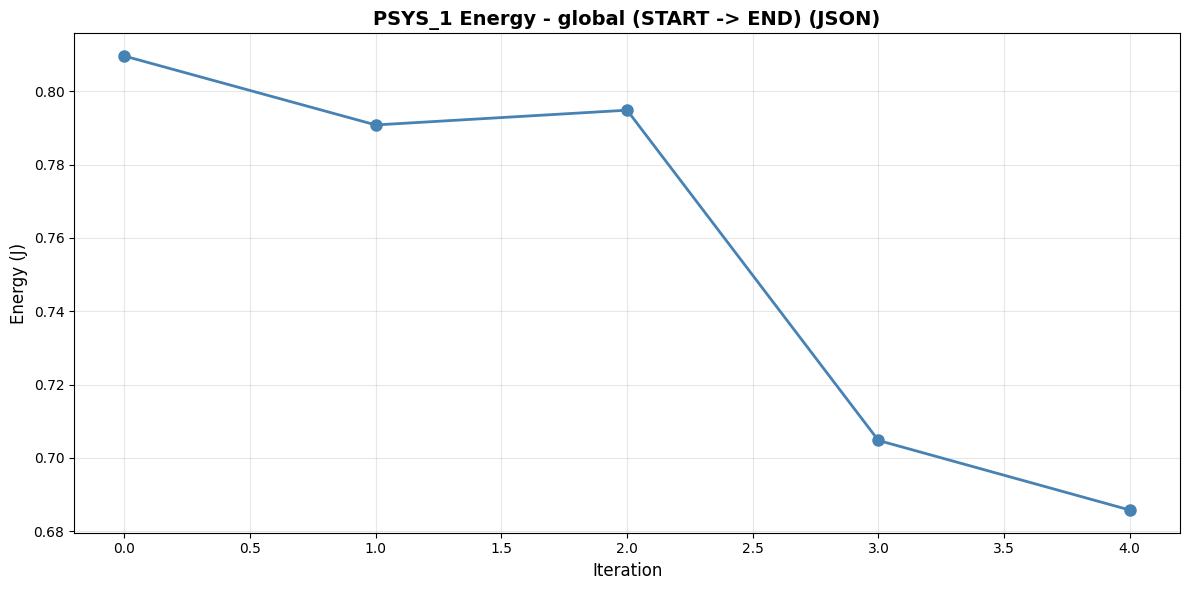

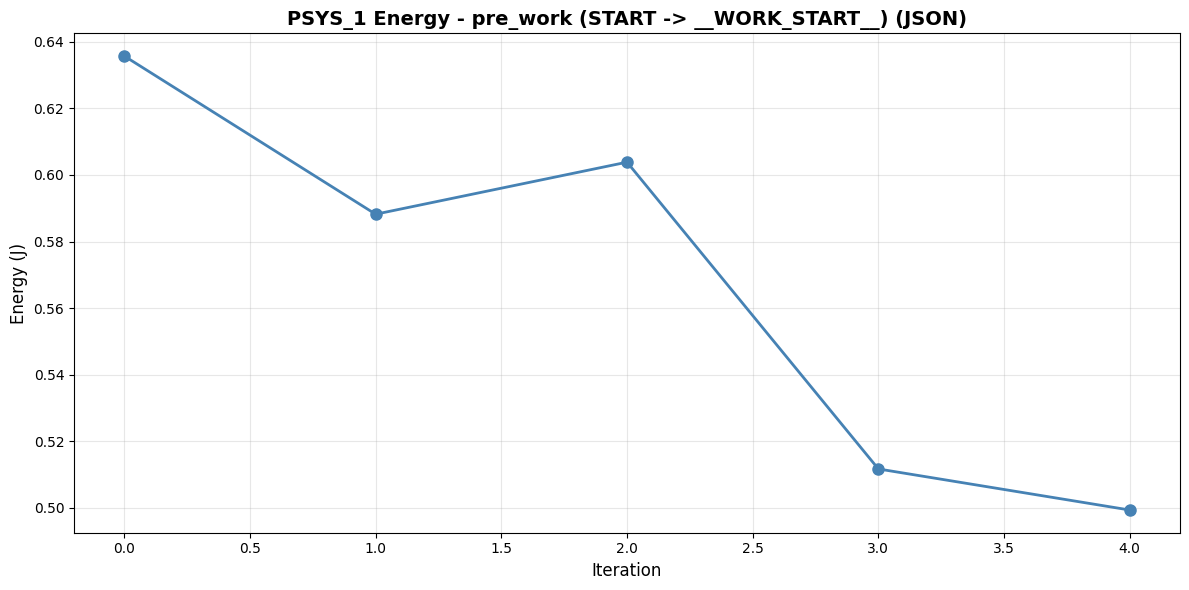

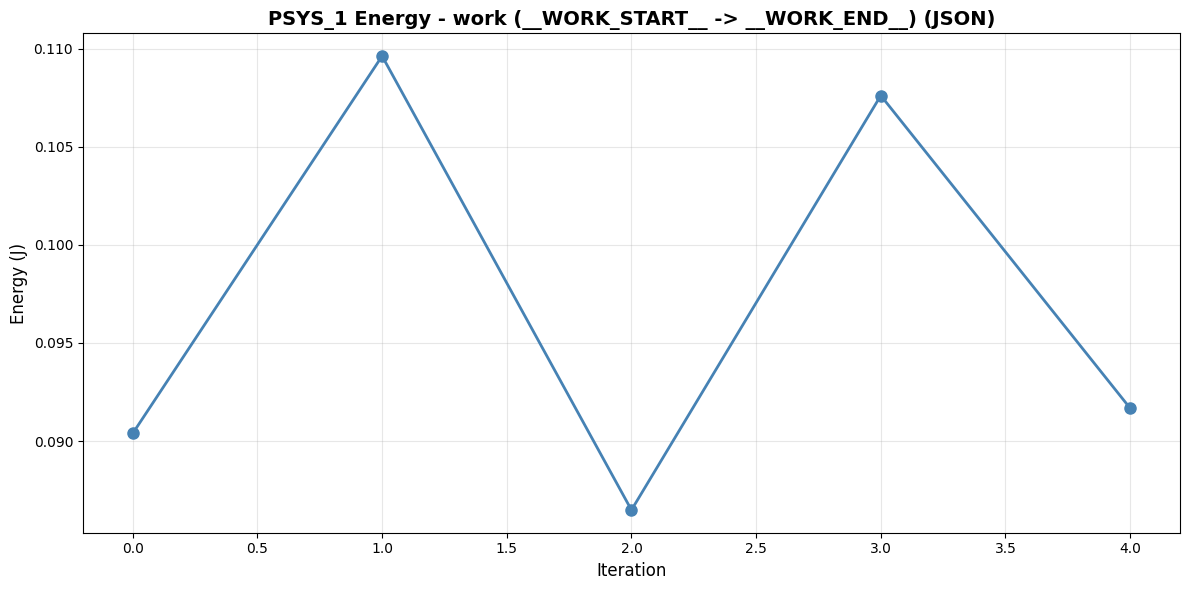

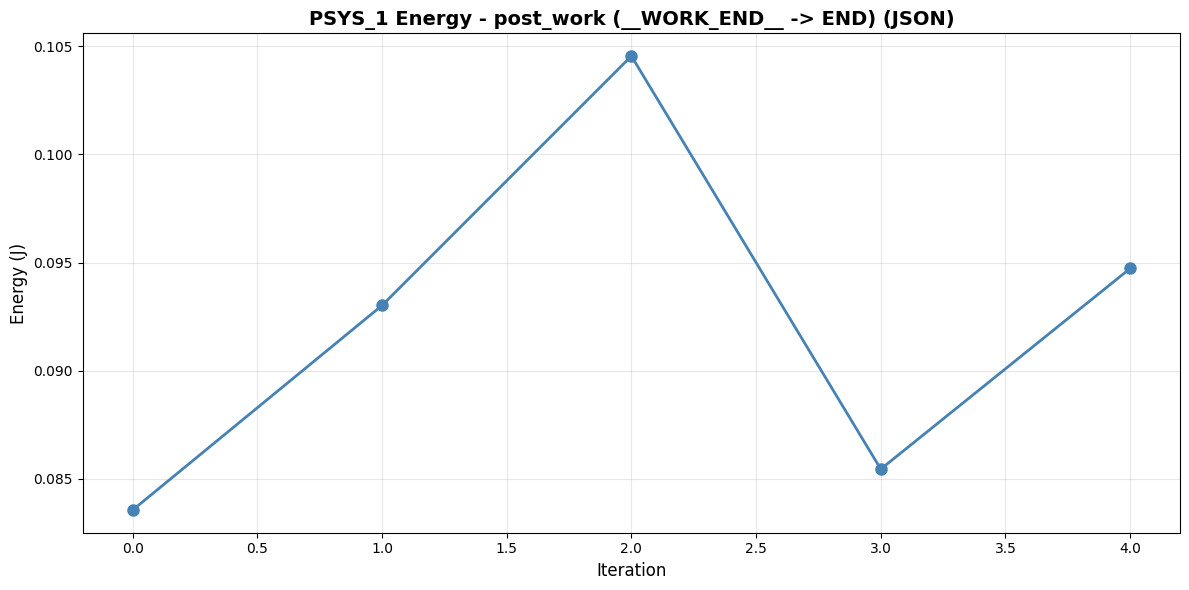

In [14]:
# Plot energy across iterations for each phase (JSON)
primary_domain_iter = None
for domain in ['PSYS_1', 'PACKAGE-0_0']:
    if domain in domain_cols_iter_json:
        primary_domain_iter = domain
        break

if primary_domain_iter:
    for phase in phases:
        phase_data = df_phases_iter_json[df_phases_iter_json['Phase'] == phase]
        
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(phase_data['Iteration'], phase_data[primary_domain_iter], 
                marker='o', linewidth=2, markersize=8, color='steelblue')
        ax.set_title(f'{primary_domain_iter} Energy - {phase} (JSON)', fontsize=14, fontweight='bold')
        ax.set_xlabel('Iteration', fontsize=12)
        ax.set_ylabel('Energy (J)', fontsize=12)
        ax.grid(alpha=0.3)
        plt.tight_layout()

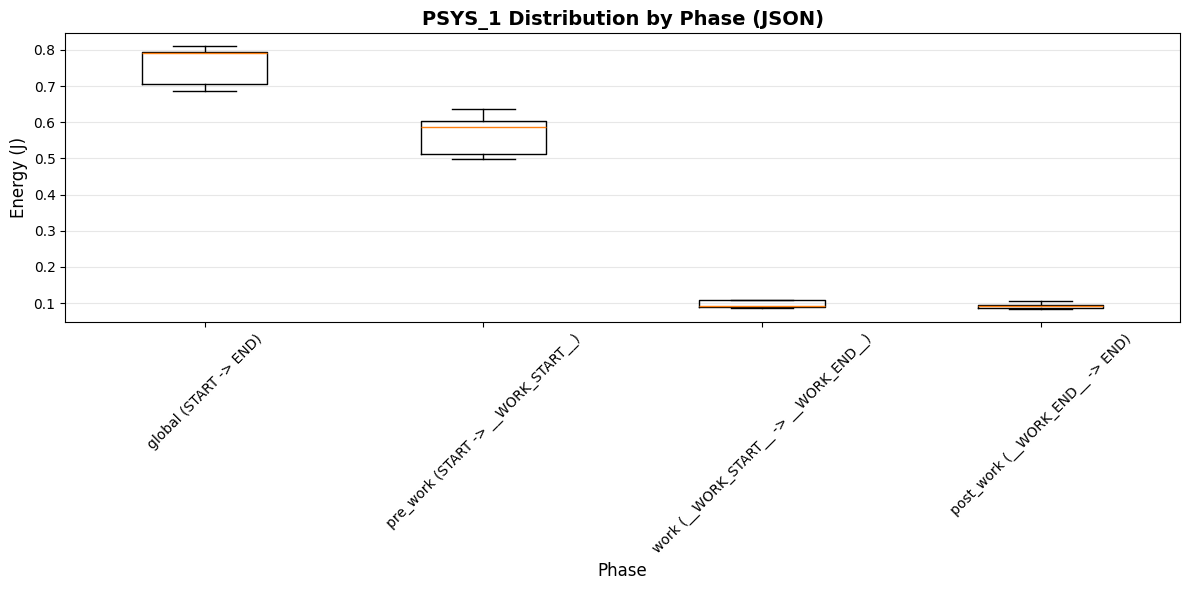

In [15]:
# Box plot - variance across iterations (JSON)
if primary_domain_iter:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    box_data = [df_phases_iter_json[df_phases_iter_json['Phase'] == phase][primary_domain_iter].values 
                for phase in phases]
    ax.boxplot(box_data, tick_labels=phases)
    ax.set_title(f'{primary_domain_iter} Distribution by Phase (JSON)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Energy (J)', fontsize=12)
    ax.set_xlabel('Phase', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()

## 4. Phases with Multiple Iterations (CSV)

In [16]:
# Load phases-iterations.csv - directly usable!
df_phases_iter_csv = pd.read_csv('../examples/data/phases-iterations.csv', sep=';')
df_phases_iter_csv.head(12)

,iteration,phase_name,CORE_0_uj,PACKAGE-0_0_uj,PSYS_1_uj,UNCORE_0_uj,duration_ms,exit_code
0,0,global (START -> END),163513,284728,764341,1709,33,0
1,0,pre_work (START -> __WORK_START__),99426,198730,592406,1709,28,0
2,0,work (__WORK_START__ -> __WORK_END__),41198,54504,108703,0,3,0
3,0,post_work (__WORK_END__ -> END),22889,31494,63232,0,2,0
4,1,global (START -> END),225280,375488,884092,2747,31,0
5,1,pre_work (START -> __WORK_START__),156066,268799,653563,2136,24,0
6,1,work (__WORK_START__ -> __WORK_END__),32959,54077,126160,0,4,0
7,1,post_work (__WORK_END__ -> END),36255,52612,104369,611,2,0
8,2,global (START -> END),187377,310546,729735,2502,28,0
9,2,pre_work (START -> __WORK_START__),133544,236816,584777,2502,22,0


In [17]:
# Get unique phases and domain columns
phases_csv = df_phases_iter_csv['phase_name'].unique()
domain_cols_iter_csv = [col for col in df_phases_iter_csv.columns if col.endswith('_uj')]

print(f"Phases: {', '.join(phases_csv)}")
print(f"Domains: {', '.join([col.replace('_uj', '') for col in domain_cols_iter_csv])}")

Phases: global (START -> END), pre_work (START -> __WORK_START__), work (__WORK_START__ -> __WORK_END__), post_work (__WORK_END__ -> END)
Domains: CORE_0, PACKAGE-0_0, PSYS_1, UNCORE_0


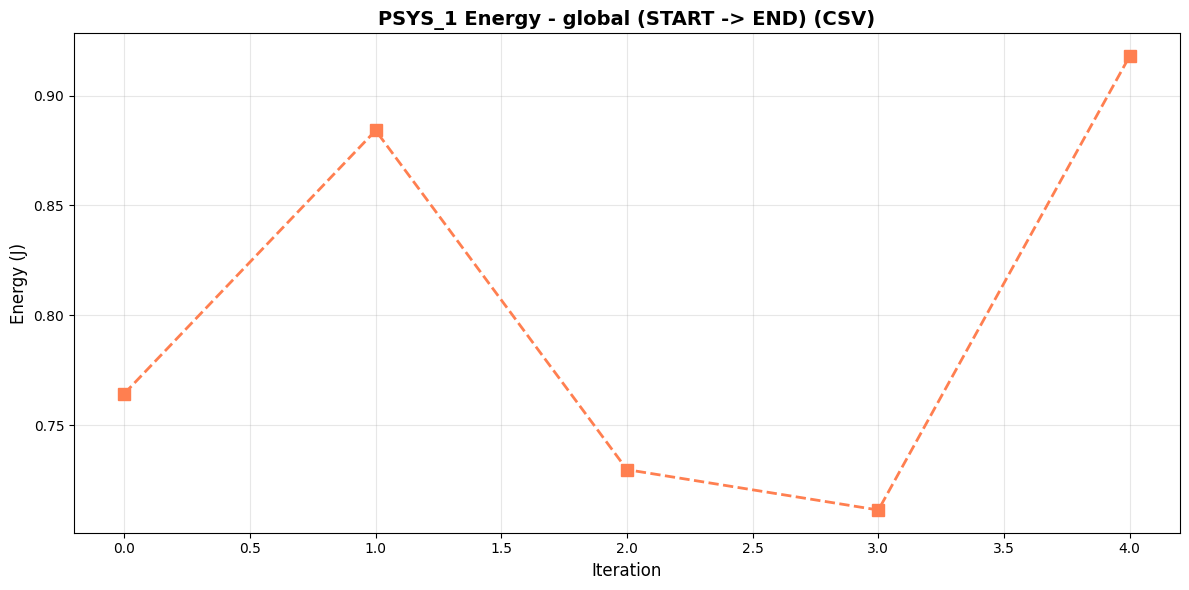

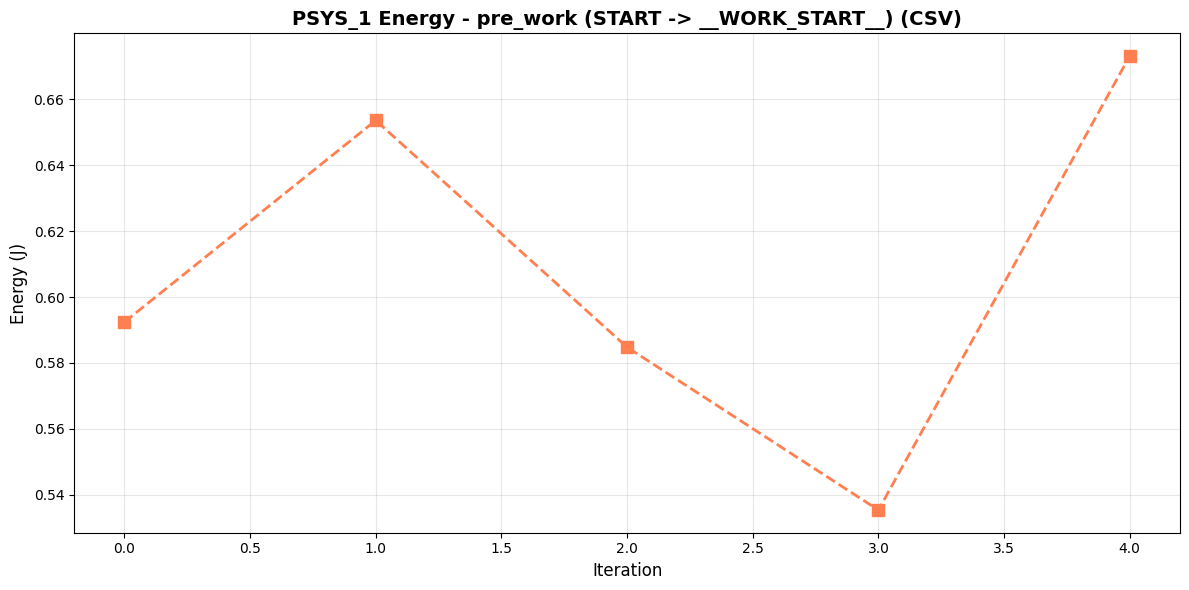

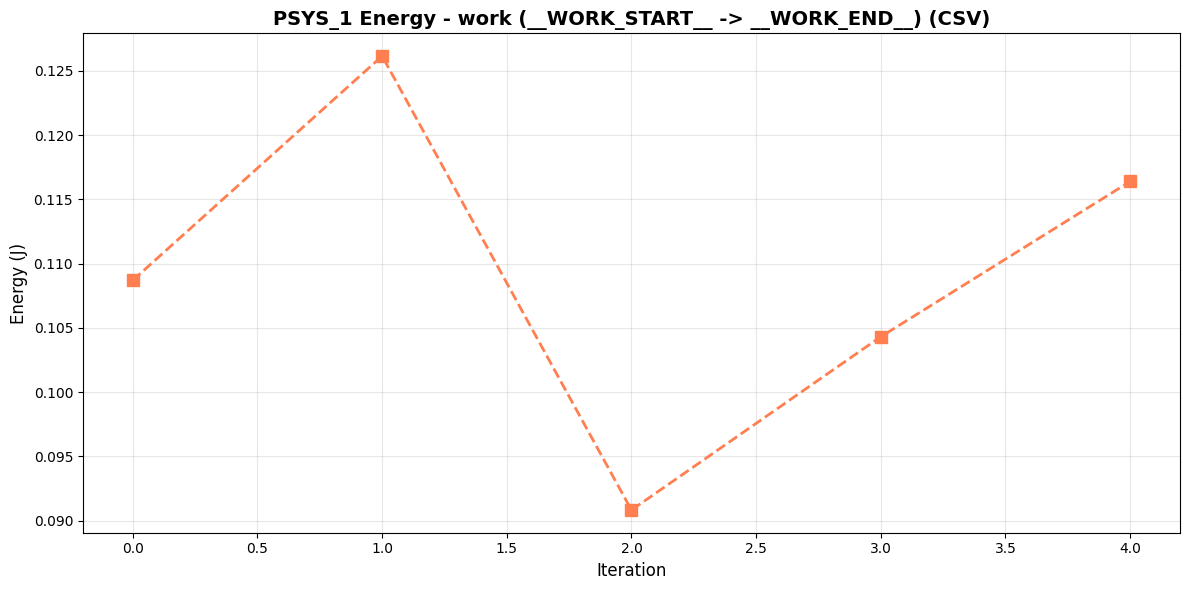

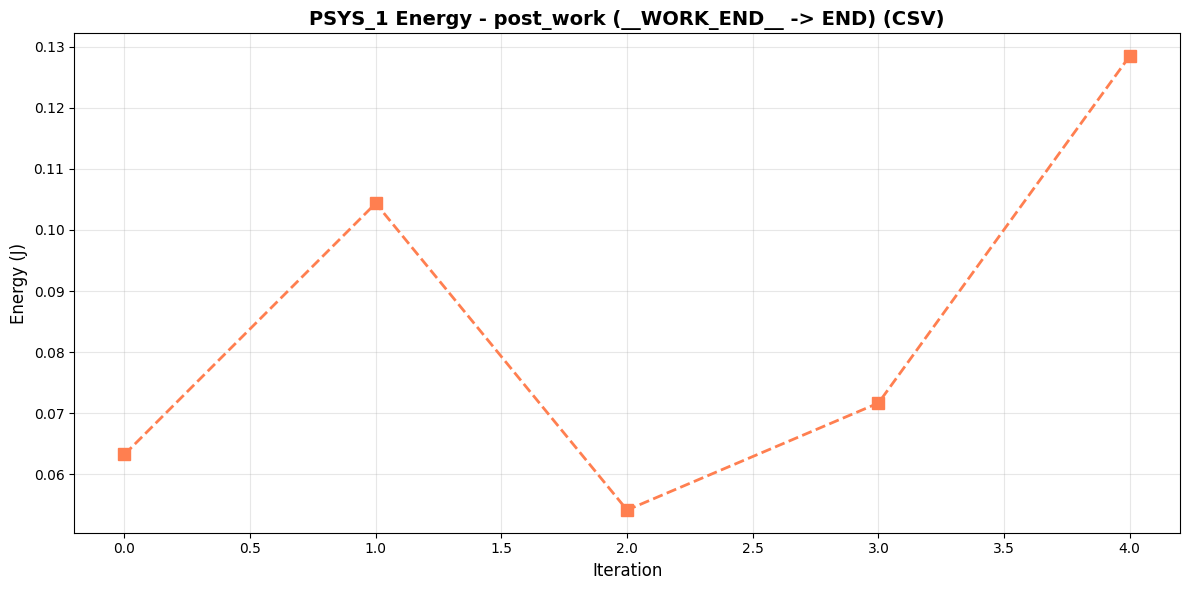

In [18]:
# Plot energy across iterations for each phase (CSV)
primary_domain_iter_csv = None
for domain in ['PSYS_1_uj', 'PACKAGE-0_0_uj']:
    if domain in domain_cols_iter_csv:
        primary_domain_iter_csv = domain
        break

if primary_domain_iter_csv:
    for phase in phases_csv:
        phase_data = df_phases_iter_csv[df_phases_iter_csv['phase_name'] == phase]
        
        fig, ax = plt.subplots(figsize=(12, 6))
        # Convert to J for display
        ax.plot(phase_data['iteration'], phase_data[primary_domain_iter_csv] / 1_000_000, 
                marker='s', linewidth=2, markersize=8, color='coral', linestyle='--')
        label = primary_domain_iter_csv.replace('_uj', '')
        ax.set_title(f'{label} Energy - {phase} (CSV)', fontsize=14, fontweight='bold')
        ax.set_xlabel('Iteration', fontsize=12)
        ax.set_ylabel('Energy (J)', fontsize=12)
        ax.grid(alpha=0.3)
        plt.tight_layout()

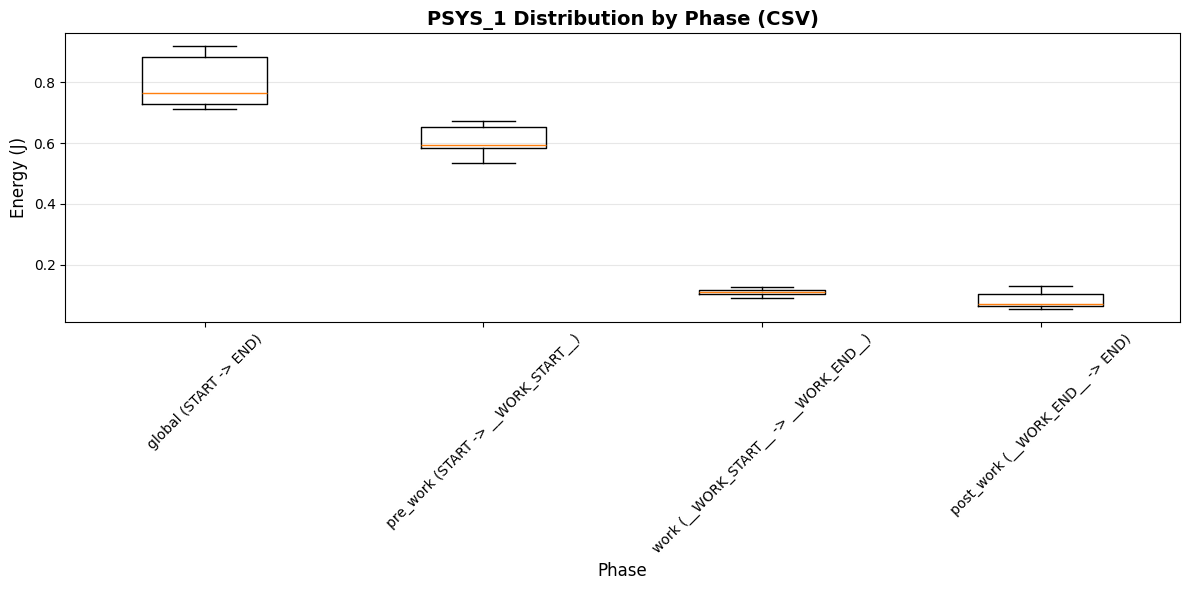

In [19]:
# Box plot - variance across iterations (CSV)
if primary_domain_iter_csv:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Convert to J for display
    box_data = [(df_phases_iter_csv[df_phases_iter_csv['phase_name'] == phase][primary_domain_iter_csv] / 1_000_000).values 
                for phase in phases_csv]
    ax.boxplot(box_data, tick_labels=phases_csv)
    label = primary_domain_iter_csv.replace('_uj', '')
    ax.set_title(f'{label} Distribution by Phase (CSV)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Energy (J)', fontsize=12)
    ax.set_xlabel('Phase', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()

## 5. Phase Statistics

In [20]:
# Statistics per phase (JSON)
if primary_domain_iter:
    print("Phase Statistics (JSON):")
    print("=" * 60)
    
    for phase in phases:
        phase_data = df_phases_iter_json[df_phases_iter_json['Phase'] == phase][primary_domain_iter]
        print(f"\n{phase}:")
        print(f"  Mean:     {phase_data.mean():.6f} J")
        print(f"  Std Dev:  {phase_data.std():.6f} J")
        print(f"  Min:      {phase_data.min():.6f} J")
        print(f"  Max:      {phase_data.max():.6f} J")
        print(f"  CV:       {(phase_data.std() / phase_data.mean() * 100):.2f}%")

Phase Statistics (JSON):

global (START -> END):
  Mean:     0.757176 J
  Std Dev:  0.057328 J
  Min:      0.685789 J
  Max:      0.809629 J
  CV:       7.57%

pre_work (START -> __WORK_START__):
  Mean:     0.567760 J
  Std Dev:  0.059469 J
  Min:      0.499388 J
  Max:      0.635679 J
  CV:       10.47%

work (__WORK_START__ -> __WORK_END__):
  Mean:     0.097155 J
  Std Dev:  0.010655 J
  Min:      0.086486 J
  Max:      0.109619 J
  CV:       10.97%

post_work (__WORK_END__ -> END):
  Mean:     0.092261 J
  Std Dev:  0.008365 J
  Min:      0.083557 J
  Max:      0.104553 J
  CV:       9.07%


In [21]:
# Statistics per phase (CSV)
if primary_domain_iter_csv:
    print("Phase Statistics (CSV):")
    print("=" * 60)
    
    for phase in phases_csv:
        phase_data = df_phases_iter_csv[df_phases_iter_csv['phase_name'] == phase][primary_domain_iter_csv] / 1_000_000
        print(f"\n{phase}:")
        print(f"  Mean:     {phase_data.mean():.6f} J")
        print(f"  Std Dev:  {phase_data.std():.6f} J")
        print(f"  Min:      {phase_data.min():.6f} J")
        print(f"  Max:      {phase_data.max():.6f} J")
        print(f"  CV:       {(phase_data.std() / phase_data.mean() * 100):.2f}%")

Phase Statistics (CSV):

global (START -> END):
  Mean:     0.801499 J
  Std Dev:  0.093597 J
  Min:      0.711363 J
  Max:      0.917966 J
  CV:       11.68%

pre_work (START -> __WORK_START__):
  Mean:     0.607848 J
  Std Dev:  0.055602 J
  Min:      0.535399 J
  Max:      0.673094 J
  CV:       9.15%

work (__WORK_START__ -> __WORK_END__):
  Mean:     0.109277 J
  Std Dev:  0.013242 J
  Min:      0.090820 J
  Max:      0.126160 J
  CV:       12.12%

post_work (__WORK_END__ -> END):
  Mean:     0.084374 J
  Std Dev:  0.031096 J
  Min:      0.054138 J
  Max:      0.128478 J
  CV:       36.86%
